In [4]:
import os 
mediu_sw_calcul='tensorflow' # "jax" sau "tensorflow" sau "torch"
# selectie backend (daca nu se apeleaza - ramane implicit tensorflow)
os.environ["KERAS_BACKEND"] = mediu_sw_calcul
# verificare backend 
import keras
import tensorflow as tf 
import numpy as np 
print('Backend: ',keras.config.backend())
print('Keras version: ',keras.__version__)

Backend:  tensorflow
Keras version:  3.5.0


#  Utilitare si verificare backend (trebuie sa fie Tensorflow)

In [5]:
# Copyright Radu and Ioana Dogaru, contact: radu.dogaru@upb.ro 
# suport discipline NA si ICI UNST Politehnica Bucuresti 
# --------------------------------------------------------------------
import keras
import time as ti 
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf 


# functie pentru truncheire - utila la printarea valorilor reale 
def truncate_float(float_number, decimal_places):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

# functie pentru conversia din format datagen in x_train x_test 
# se preiau un numar bine precizat de "batch-uri"
# Copyright Radu Dogaru, 1 June 2024 
#------------------------------------------------------------
def conv_tensor(datagen, num_batches):
    for x_test, y_test in datagen:
            break;
    for b in range(num_batches-1):
        for x, y in datagen:
            break;
        x_test= tf.concat([x_test, x], axis=0)
        y_test= tf.concat([y_test, y], axis=0)
    return x_test, y_test
# "Helper" pentru evaluarea acuratetii pe modelul .tflite 
#--------------------------------------------------------------------
# Se ruleaza o data - util pentru a prezice acuratetea 
# adaptat dupa: https://www.tensorflow.org/lite/performance/post_training_quant 
# Copyright Radu Dogaru, May 2024 radu.dogaru@upb.ro 
# 
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, num_batches, x_test, y_test):  # num_batches only if you use validation_generator 
  if datagen==True:
    # prepare some x_test y_test data for num_batches 
    if test_exists:
        x_test,y_test=conv_tensor(datagen=test_generator, num_batches=num_batches)
    else: 
        x_test,y_test=conv_tensor(datagen=validation_generator, num_batches=num_batches)
  ync_test=np.int16(np.dot(y_test,np.array(range(num_classes))))
  input_index = interpreter.get_input_details()[0]["index"] 
  output_index = interpreter.get_output_details()[0]["index"]
  
  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  durata=0 
  for test_image in x_test:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  
    interpreter.set_tensor(input_index, test_image)
    t1=ti.time()
    # Run inference.
    interpreter.invoke()
    t2=ti.time()
    durata += (t2-t1)  
    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.get_tensor(output_index)  # s-a modificat la get_tensor (varianta tensor nu mai este actuala !!!)
    digit = np.argmax(output, axis=1) 
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == ync_test[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)
  C=confusion_matrix(prediction_digits,ync_test)  # matricea de confuzie pe model .tflite 
  print(C)
  print(classification_report(ync_test, prediction_digits ))
  return accuracy, prediction_digits, 1000*durata/len(prediction_digits)


In [6]:
# Copiem imaginile în acest folder , utila pentru dataset-urile care nu sunt organizate normal in fisiere de train si test ci avem doua fisiere cu imagini fara etichete
def copy_images_2_dir(data, dest_folder):
    for _, row in data.iterrows():
        img_name = row['image_id'] + ".jpg"
        class_name = row['dx']
        search_path = os.path.join(img_dir1, img_name) if os.path.exists(os.path.join(img_dir1, img_name)) else os.path.join(img_dir2, img_name)
        dest_path = os.path.join(dest_folder, class_name, img_name)
        shutil.copy(search_path, dest_path)


# Functie utila pentru dataset-urile care nu sunt organizate normal in fisiere de train si test ci avem un singur fisier cu imagini fara etichete
def copy_images_1_dir(data, dest_folder):
    for _, row in data.iterrows():
        img_name = row['image'] + ".jpg"  # Presupunem că imaginile sunt .jpg
        src_path = os.path.join(img_dir, img_name)
        
        # Verifică dacă imaginea există
        if not os.path.exists(src_path):
            continue
        
        # Găsește eticheta activă (unde valoarea este 1)
        for label in disease_labels:
            if row[label] == 1:
                dest_path = os.path.join(dest_folder, label, img_name)
                shutil.copy(src_path, dest_path)


In [7]:
!ls /kaggle/input/skin-cancer-mnist-ham10000

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


In [8]:
!ls /kaggle/input/ham1000-segmentation-and-classification

ls: cannot access '/kaggle/input/ham1000-segmentation-and-classification': No such file or directory


In [9]:
!ls /kaggle/input/skin-cancer9-classesisic

ls: cannot access '/kaggle/input/skin-cancer9-classesisic': No such file or directory


# 1. Se incarca setul de date dorit (specificat ca dataset)

# 1.1

In [10]:
import os
import shutil
import pandas as pd
import keras
import numpy as np 
from keras.utils import image_dataset_from_directory as imdir
#-----------------------------------------------------------------------------
imsize = 64    # alegeti dimensiunea de lucru a datelor (de regula permite optimizarea )
batch_size= 8012  #8012 #7684 (binary)  # marimea pachetului de date - cam 1% din total date 
sbatch_size= 2003 #2003  #1921(binary)    # batch size pe setul de validare 

# Nota: daca se foloseste conversia la format tensor se aleg cele 2 valori egale cu nr de fisiere (se ruleaza 
#prima data cu batch_size=sbatch_size=32)

dataset='ham10000' # unul dintre seturile de date acoperite 
# verificati (in Kaggle) ca ati adaugat (add input) setul preluand in fereastra de cautare link-ul din location 

#-------------- dataset properties 
datagen=True # forma de acces la date 


if dataset=='ham10000':
    # https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000?select=HAM10000_images_part_2
    # !! 2.9Gbyte 
    SPL =True # Folosim split-ul automat
    # Calea către imagini
    img_dir1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
    img_dir2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
    metadata_file = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

    # Citim fișierul CSV cu etichetele
    df = pd.read_csv(metadata_file)

    # Creăm un singur folder unde punem toate imaginile organizate pe clase
    train_dir = "/kaggle/working/my_skin_dataset"
    os.makedirs( train_dir, exist_ok=True)

    classes = df['dx'].unique()  # Lista cu toate etichetele disponibile
    for class_name in classes:
        os.makedirs(os.path.join( train_dir, class_name), exist_ok=True)

    copy_images_2_dir(df,  train_dir)  # Punem toate imaginile într-un singur loc
    
    test_exists = False  # Nu avem un set de test separat
    #N_test=1000

elif dataset=='binary':
    #location https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
    SPL=True

    train_dir='/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train'
    test_dir='/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test'
    test_exists=True
    N_test=100
    

# ---- constructie data-gens : ----------------

if SPL:
    train_generator = imdir(
        directory=train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        validation_split=0.2, # numai daca nu sunt deja despartite 
        subset='training', # numai daca nu sunt deja impartite 
        seed=34,  # numai daca nu sunt deja impartite 
        image_size=(imsize, imsize))
    validation_generator = imdir(
        directory=train_dir,  # train_dir daca este un singur director 
        labels='inferred',
        label_mode='categorical',
        batch_size=sbatch_size,
        shuffle=True,
        validation_split=0.2, # numai daca nu sunt deja despartite 
        subset='validation', # numai daca nu sunt deja impartite 
        seed=34, # numai daca nu sunt deja impartite 
        image_size=(imsize, imsize))
else:     
    train_generator = imdir(
        directory=train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        image_size=(imsize, imsize))
    validation_generator = imdir(
        directory=val_dir,  # train_dir daca este un singur director 
        labels='inferred',
        label_mode='categorical',
        batch_size=sbatch_size,
        shuffle=True,
        image_size=(imsize, imsize))
if test_exists: 
    test_generator = imdir(
        directory=test_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=N_test,  # ideal ar fi sa fie egal cu numar esantioane 
                      # dar pot aparea probleme de "exhausted" 
        shuffle=True,
        image_size=(imsize, imsize))

#-------------------------------------------------

num_classes=np.shape(train_generator.class_names)[0]

# --- la finalul celulei care asociaza datele se genereaza num_classes si input_shape care vor fi utilizate ca 
# intrare de diferitele modele neuronale 

xt,yt=conv_tensor(train_generator, num_batches=1)
input_shape=(xt.shape[1], xt.shape[2], xt.shape[3])

if datagen:
    x_test, y_test= conv_tensor(datagen=validation_generator, num_batches=1)
print('pixel maxim: ',np.max(x_test))
print('input shape: ', x_test.shape[1:4])  # putem vedea daca este citit in format TF sau PYTORCH

print('numar clase: ', num_classes, ' format intrare : ', input_shape)
print('Class names: ',train_generator.class_names)  # un numar mai mic de clase 

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
pixel maxim:  255.0
input shape:  (64, 64, 3)
numar clase:  7  format intrare :  (64, 64, 3)
Class names:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


# Adaugat R.D. 14 feb 2025 - conversie in format tensor (pemntru o antrenare mai accelerata). 
Nota: se va relua rularea celor de sus cu alegerea batch_size=xxxx (de ex. xxxx=8012) si sbatch_size= yyyy (yyyy = 2003 files for validation) 


In [12]:
# Conversie in format tensor (copyright Radu and Ioana Dogaru )
#====================================================================
datagen=False
x_train, y_train= conv_tensor(datagen=train_generator, num_batches=1)
x_test, y_test= conv_tensor(datagen=validation_generator, num_batches=1)
# conversie in format numpy (altfel sunt in format tf si nu e Ok pentru salvare model )
x_train=np.asarray(x_train); x_test=np.asarray(x_test); 
y_train=np.asarray(y_train); y_test=np.asarray(y_test); 
print('Training samples: ',np.shape(x_train)[0]); print('Esantioane test: ',np.shape(x_test)[0]);
#print('Input data shape : ', np.shape(x_train)[1], 'x', np.shape(x_train)[2] )
num_classes=np.shape(train_generator.class_names)[0]
print('Number of classes: ',num_classes)
input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])
print('Input shape: ',input_shape)

Training samples:  8012
Esantioane test:  2003
Number of classes:  7
Input shape:  (64, 64, 3)


## Imagini dupa preprocesare

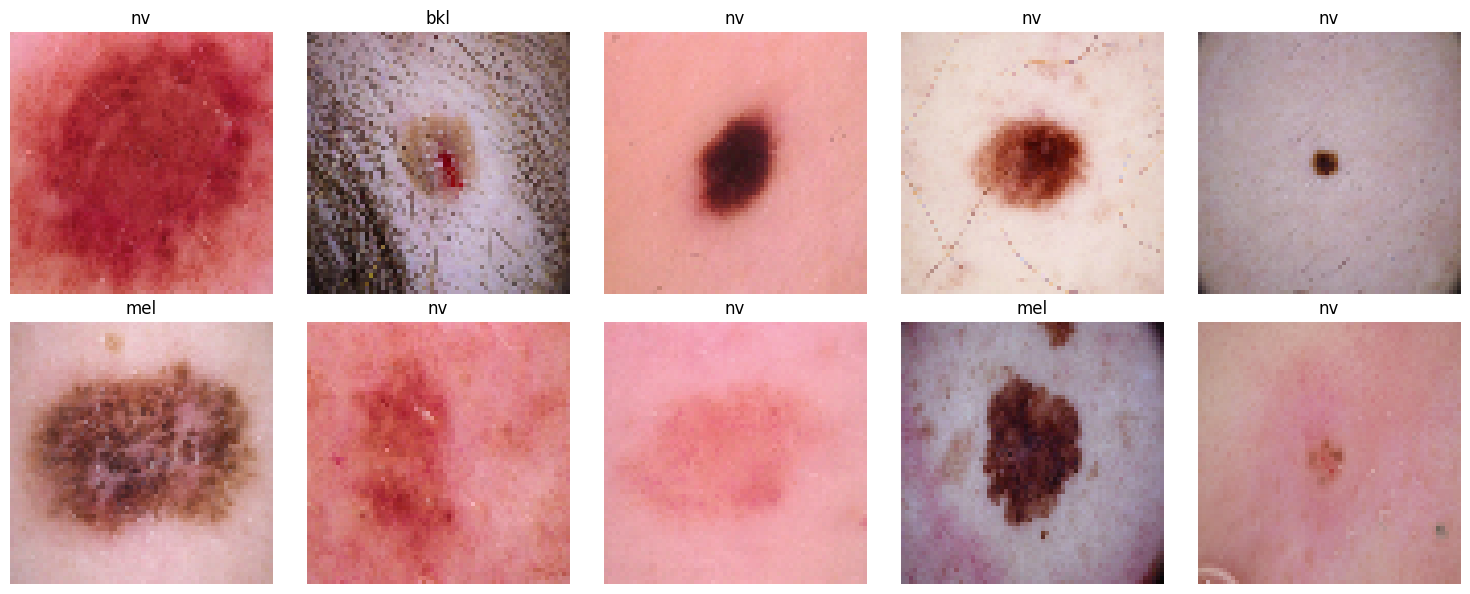

In [13]:
import matplotlib.pyplot as plt

def afiseaza_imagini(x_data, y_data, class_names, numar=10):
    # Normalizăm imaginile dacă valorile sunt între 0–255
    if x_data.max() > 1:
        x_data = x_data / 255.0

    plt.figure(figsize=(15, 6))
    for i in range(numar):
        plt.subplot(2, numar//2, i+1)
        plt.imshow(x_data[i])
        label_idx = np.argmax(y_data[i])  # una dintre clasele one-hot
        plt.title(class_names[label_idx])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Apelează funcția
afiseaza_imagini(x_train, y_train, train_generator.class_names, numar=10)

## Distribuția imaginilor pe clase în seturile de antrenament și test

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def afiseaza_distributie_date(y_train, y_test, class_names):
    # Convertim etichetele one-hot în etichete numerice
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculăm frecvențele pentru fiecare clasă
    train_counts = np.bincount(y_train_labels)
    test_counts = np.bincount(y_test_labels)

    x = np.arange(len(class_names))  # Indicii claselor
    width = 0.35  # Lățimea barelor

    # Creăm figura
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

    # Adăugăm etichete și titluri
    ax.set_ylabel('Număr de imagini')
    ax.set_title('Distribuția imaginilor pe clase în seturile de antrenament și test')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()

    # Etichete deasupra fiecărei bare
    def adauga_etichete(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puncte deasupra
                        textcoords="offset points",
                        ha='center', va='bottom')

    adauga_etichete(rects1)
    adauga_etichete(rects2)

    plt.tight_layout()
    plt.show()

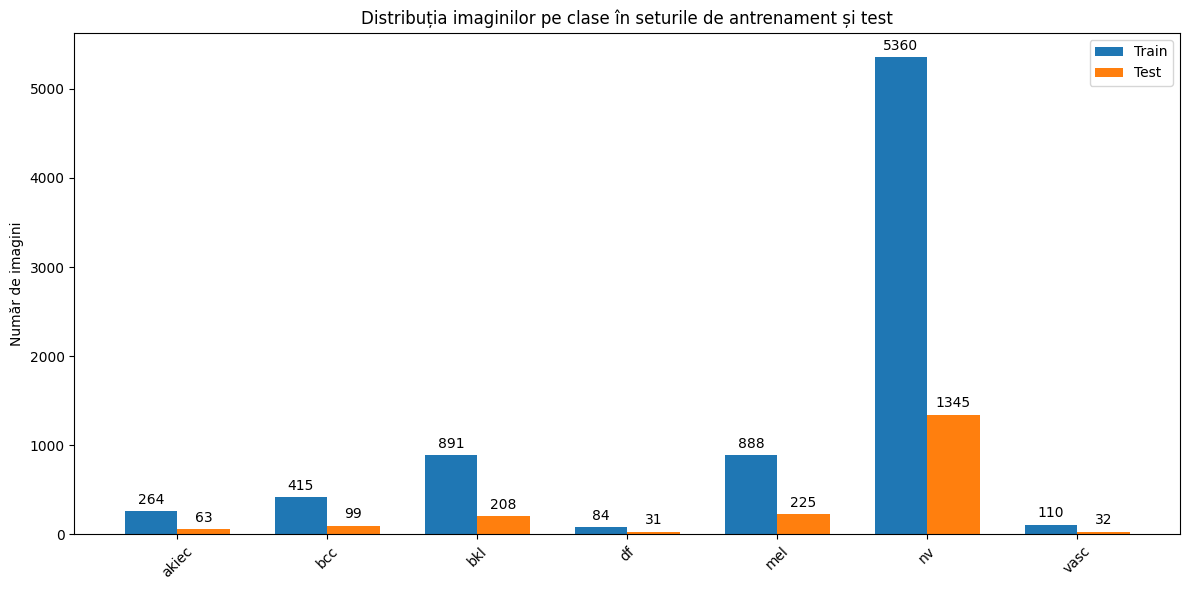

In [16]:
afiseaza_distributie_date(y_train, y_test, train_generator.class_names)

# 1.2
# Adaugat 14 feb 25 - citire in format tensor skin-mnist (deja segmentate si balansate, se obtine o perf. f buna)
balansat == numar relativ egal de esantioane in fiecare clasa dimensiunea este de asemenea convenabila 28x28

In [17]:
# Citire date skin mnist 
# Copyright Radu and Ioana Dogaru, feb. 2025 
#====================================================
my_data_path='/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
# location https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000 

# ideea de balansare de aici https://www.kaggle.com/code/abdallahwagih/skin-cancer-detection 
# Datele NU sunt scalate ! 

dataset='skin-mnist'
import pandas as pd
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split

datagen=False # forma de acces la date 
test_exists=False
out_coding='cat'   # non or cat If categorical coding is chosen 
in_coding='clast'

data = pd.read_csv(my_data_path)
y = data['label']   # format non-cat 
x = data.drop(columns = ['label']) # format non-imagine - trebuie re-organizat 
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)
x = np.array(x).reshape(-1,28,28,3)
#x = (x-np.mean(x))/np.std(x)   # scalare 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)
x_train=x_train.astype('float32') # necesare pentru buna functionare a cuantizarii INT8 
x_test=x_test.astype('float32')  #
y_train=np.array(y_train)
y_test=np.array(y_test)

classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}
num_classes=len(classes)

if out_coding=='cat':
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)


input_shape=np.shape(x_train)[1:4]
imsize=input_shape[0]

print('Training samples: ',np.shape(x_train)[0]); print('Esantioane test: ',np.shape(x_test)[0]);
#print('Input data shape : ', np.shape(x_train)[1], 'x', np.shape(x_train)[2] )
print('Number of classes: ',num_classes)
print('Input shape: ',input_shape)





Training samples:  37548
Esantioane test:  9387
Number of classes:  7
Input shape:  (28, 28, 3)


## Imagini dupa preprocesare

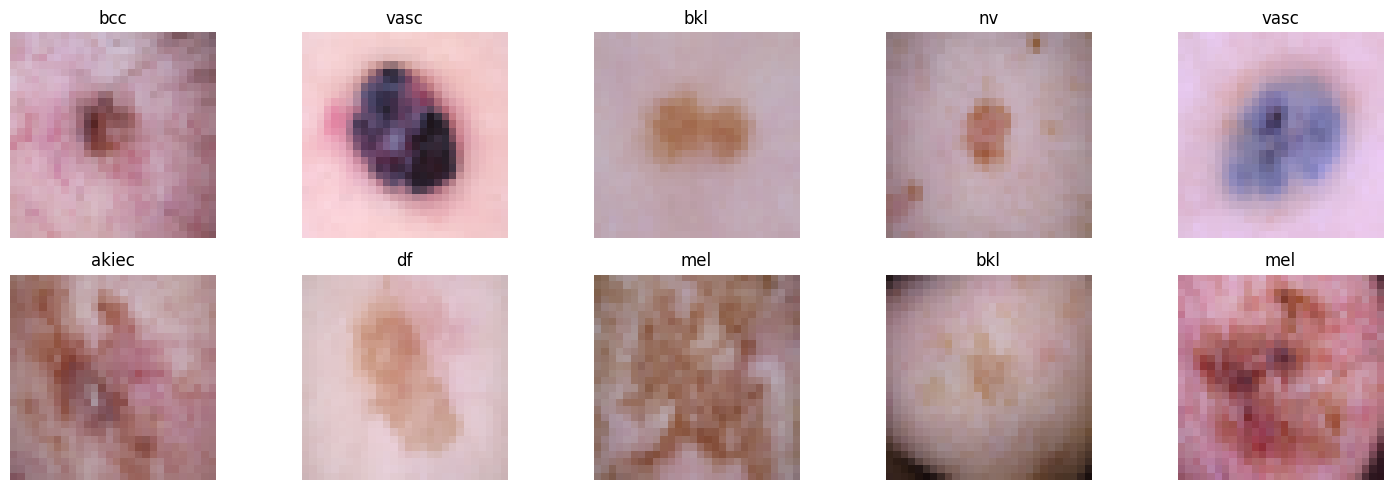

In [18]:
import matplotlib.pyplot as plt

def afiseaza_primele_imagini(x_data, y_data, clase, numar=10):
    plt.figure(figsize=(15, 5))
    for i in range(numar):
        plt.subplot(2, numar//2, i+1)
        plt.imshow(x_data[i].astype("uint8"))  # dacă valorile sunt 0–255
        if y_data.ndim > 1:  # dacă este one-hot encoded
            label_index = np.argmax(y_data[i])
        else:
            label_index = y_data[i]
        label = clase[label_index][0]
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

afiseaza_primele_imagini(x_train, y_train, classes, numar=10)

## Distribuția imaginilor pe clase în seturile de antrenament și test

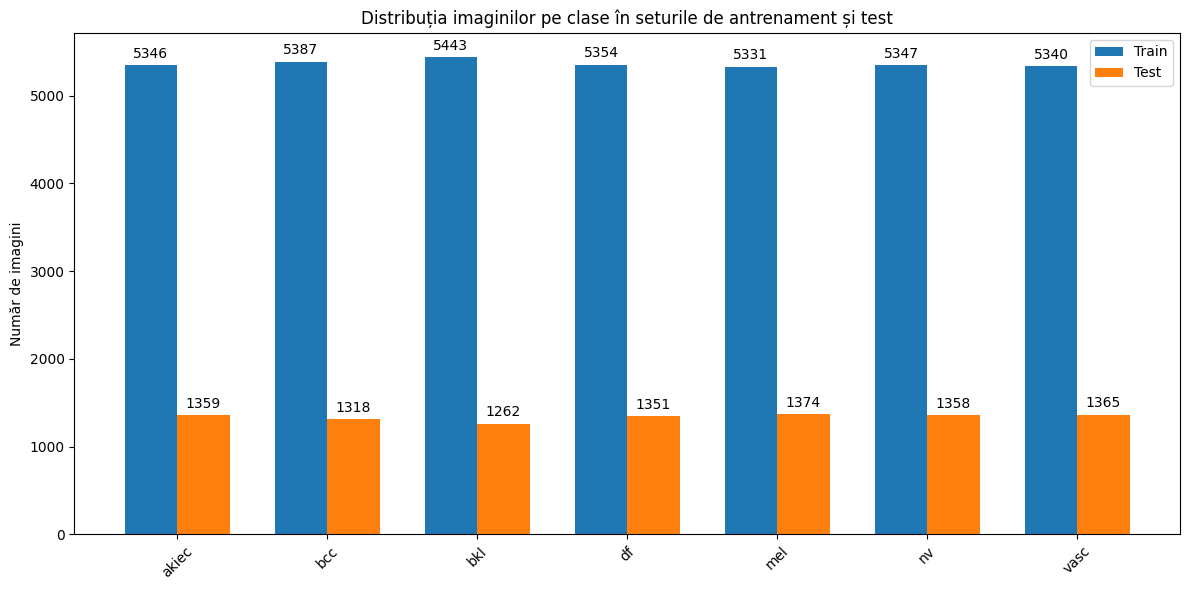

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def afiseaza_distributie_date(y_train, y_test, class_names):
    # Convertim etichetele one-hot în etichete numerice
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculăm frecvențele pentru fiecare clasă
    train_counts = np.bincount(y_train_labels)
    test_counts = np.bincount(y_test_labels)

    x = np.arange(len(class_names))  # Indicii claselor
    width = 0.35  # Lățimea barelor

    # Creăm figura
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

    # Adăugăm etichete și titluri
    ax.set_ylabel('Număr de imagini')
    ax.set_title('Distribuția imaginilor pe clase în seturile de antrenament și test')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()

    # Etichete deasupra fiecărei bare
    def adauga_etichete(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puncte deasupra
                        textcoords="offset points",
                        ha='center', va='bottom')

    adauga_etichete(rects1)
    adauga_etichete(rects2)

    plt.tight_layout()
    plt.show()

afiseaza_distributie_date(y_train, y_test, train_generator.class_names)

# 2. Modele neuronale
## 2.1.Definire model VRES-CNN



In [20]:
# # Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA  UNST Politehnica Bucuresti 
#--------------------------------------------------------------------------
# Model VRES-CNN 
# Copyright Radu & Ioana Dogaru, May 2024 
# code in support of paper  https://github.com/radu-dogaru/vres-cnn/blob/main/ECAI_2024_Paper_Dogaru.pdf (please cite the paper if you find it useful)
#  
#-----------------------------------------------------------------------
import numpy as np 
from keras.layers import Input, Conv2D, SeparableConv2D, ReLU, BatchNormalization,\
                                    Add, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, \
                                    Flatten, Dense, Dropout, Activation, Identity, Concatenate
from keras.models import Model



def svcnn_resblock(x, filters, nl, resid=True, separ=True, myact='hard_silu'):
    # filters and nl regarding macro-block
    # csize=3 = economical, 5 gives faster convergence but not so light
    csize=3; stri=2; psiz=4; pad='same';  # psiz=3 pana pe 19 iunie 2024 (rezultate articol) !! p=4 optim 
    drop1=0.5 # One may try other values e.g. 0.5 
    if nl>0:
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(x)
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(x)
        z=y
        y=Activation(myact)(y)
        for nonlin in range(1,nl):
            if separ:
                y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(y)  # aici era (z) inainte de 5 iul ora 20
            else:
                y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(y)  # aici era (z) inainte de 5 iul ora 20
            y=Activation(myact)(y)
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(y)# Activ NL-CNN-2
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(y)#
    else:
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize) )(x)  # Activ NL-CNN-2
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize) )(x)  # Activ NL-CNN-2
        z=y

    if resid:
        out = Add()([z, y])
    else:
        out=y
    # cap 
    out=BatchNormalization()(out)  # Comment if no batch normalization ... 
    out=MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad)(out)
    out=Dropout(drop1)(out)   # If missing, very low performance and overfit present. 
    return out

def create_vres_cnn(input_shape, num_classes, myact='relu', flat=1, fil=[100,100,100,100], nl=[1,1,0,0], hid=[], resid=True, separ=True, scale=True):
    # Note the number of elements in fil list (macrolayers) should be the same in nl list
    # hid can be [] while if the are elements, additional dense layers are added in the output classifier
    my_opt=keras.optimizers.Adam(learning_rate=0.001) # learning_rate=0.0001 may be changed 
    nfilmax=np.shape(np.array(fil))[0]
    if scale:
        inputs = Input(shape=input_shape) / 255 #
    else:
        inputs = Input(shape=input_shape)
    #============= MODULE MAIN =======================================================
    # First macrolayer - connected to input  ----------------
    if nfilmax>0:
    # Cazul cu straturi convolutionale 
        layer=0
        #print('layer: ',layer,' nl: ',nl[layer])
        t=svcnn_resblock(inputs, fil[layer], nl[layer], resid, separ, myact)
        for layer in range(1,nfilmax):
            #print('layer: ',layer,' nl: ',nl[layer])
            t=svcnn_resblock(t, fil[layer], nl[layer], resid, separ, myact)
    else: 
    # Cazul fara convolutii 
        t=inputs
    # Exit classifier
    # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice )
    if flat==1:
        t=Flatten()(t)  # alternanta cu GlobalAv ..
    elif flat==0:
        t=GlobalAveragePooling2D()(t) # pare sa fie mai Ok la cifar
    #=============== END MODULE MAIN - BEGIN MODULE 2 =================

    nhid=np.shape(np.array(hid))[0]
    if nhid>0:
        for lay in range(nhid):
            t=Dense(hid[lay], activation='relu')(t)
            #model.add(Dropout(drop1))
    outputs =Dense(num_classes, activation='softmax')(t)
    model = Model(inputs, outputs)
# END OF MODEL DESCRIPTION 
    my_loss='categorical_crossentropy'
    model.compile(loss=my_loss,   # categorical_crossentropy / crossentropy (POytorch data gen) 
                      optimizer=my_opt, 
                      metrics=['accuracy'])
    model.build(input_shape)
    return model

### 2.1.1. instantierea modelul V(RES)-CNN cu hiper-parameterii doriti

In [21]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA  UNST Politehnica Bucuresti 
##--------------------------------------------------------------------
# aici se vor modifica hiperparam. conform tabelului de lucru
version='VRES' # VRES V VR SV   # VRES este cea mai compacta ; V = VCNN 
#  sunt cu probleme: VR - loss=nan ?? ; V - .tflite difera f. mult ; # de rezolvat !
#  sunt ok: SV VRES  - deci problemele sunt la separable ... 

myact='relu'  # sau 'hard_silu' 
myscale=True  # 
myflat=0; myfil=[70, 80, 90, 100]; mynl=[2, 1, 1, 1]; myhid=[]   # aici se pot testa diferite alte valori 
#--------------------------------------------------------------------------------------------
if myscale==False: 
    mys='N'
elif myscale==True:
    mys='S'
if version=='VRES':
        my_resid=True
        my_separ=True
elif version == 'V':
        my_resid=False
        my_separ=False
elif version == 'VR': 
        # loss = nan - de verificat cauza !
        my_resid=True
        my_separ=False
elif version == 'SV':
        my_resid=False
        my_separ=True 
model=create_vres_cnn(input_shape, num_classes, myact=myact, flat=myflat, fil=myfil, nl=mynl, hid=myhid, resid=my_resid, separ=my_separ, scale=myscale)
model_name=version+'_'+mys+myact[0]+str(myflat)+'_'+str(myfil)+'_'+str(mynl)+'_'+str(myhid)
print(model_name)
model.summary()

VRES_Sr0_[70, 80, 90, 100]_[2, 1, 1, 1]_[]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE       │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 28, 28, 70)     │            307 │ keras_tensor_1CLONE[1… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 28, 28, 70)     │              0 │ separable_conv2d[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 28, 28, 70)     │          5,600 │ activation[1][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 28, 28, 70)     │              0 │ separable_conv2d_1[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 28, 28, 70)     │          5,600 │ activation_1[1][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 28, 28, 70)     │              0 │ separable_conv2d[1][0… │
│                           │                        │                │ separable_conv2d_2[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 28, 28, 70)     │            280 │ add[1][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 14, 14, 70)     │              0 │ batch_normalization[1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 14, 14, 70)     │              0 │ max_pooling2d[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 14, 14, 80)     │          6,310 │ dropout[1][0]          │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 14, 14, 80)     │              0 │ separable_conv2d_3[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 14, 14, 80)     │          7,200 │ activation_2[1][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 14, 14, 80)     │              0 │ separable_conv2d_3[1]… │
│                           │                        │                │ separable_conv2d_4[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 65,004 (253.92 KB)

 Trainable params: 64,324 (251.27 KB)

 Non-trainable params: 680 (2.66 KB)

# Alte modele neuronale

## 2.2 EfficientNet pentru imagini de dimensiuni mai mari

In [8]:
from keras.applications import EfficientNetB0
from keras.layers import Input, Resizing ,Conv2D, SeparableConv2D, ReLU, BatchNormalization,\
                                    Add, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, \
                                    Flatten, Dense, Dropout, Activation, Identity, Concatenate
from keras.models import Sequential


sparse=False 
out_coding='cat'
my_opt=keras.optimizers.Adam(learning_rate=0.01)

base_model = EfficientNetB0(weights='imagenet', include_top=False ,  input_shape=(64,64,3)) # transforma la mod Seq.  
base_model.trainable = True  #True #False # poate fi si True - dureaza antrenarea mai mult dar perf. mai buna 

# Model EfficientB0 propus 
top_dropout_rate = 0.2
inputs=Input(shape=input_shape)
x = Resizing(64,64)(inputs)
x=Conv2D(32, padding='same', kernel_size=(3, 3))(x)
x=BatchNormalization()(x)
x=ReLU()(x)
x=Conv2D(3, padding='same', kernel_size=(3, 3))(x)
x=base_model(x)
x=GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs=Dense(num_classes, activation='softmax')(x)

# End model 


model = keras.Model(inputs, outputs, name="EfficientNet")

# Compilarea modelului
# END OF MODEL DESCRIPTION 
if sparse: 
        model.compile(
            #optimizer=my_opt,
            optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
            )
else: 
        if out_coding=='cat':
            my_loss='categorical_crossentropy'
        elif out_coding=='non':
            my_loss='crossentropy'
        model.compile(loss=my_loss,   # categorical_crossentropy / crossentropy (POytorch data gen) 
                      optimizer=my_opt, 
                      metrics=['accuracy'])
#model.build(input_shape)
model_name='EffB0_pretrained' + '_bmt_'+ str(base_model.trainable)
print(model_name)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EffB0_pretrained_bmt_True


Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 3)           │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 2, 2, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ top_dropout (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,712,973 (17.98 MB)

 Trainable params: 4,669,862 (17.81 MB)

 Non-trainable params: 43,111 (168.41 KB)

## 2.3. Se poate incerca cu MobileNet backbone ...
un model care se adapteaza la dimensiunile (mai mici) decat 224x224 (cele "pretrained sunt configurate si eficiente pentru 224x224 dar nu dau performante bune pe intrari cu dim. diferite. Mai jos un exemplu dar nu e definitivat. Ref: https://keras.io/api/keras_cv/models/backbones/mobilenetv3/

In [21]:
# adaptat dupa https://keras.io/keras_hub/api/models/mobilenet/mobilenet_backbone/
from keras_cv.models import MobileNetV3Backbone, ImageClassifier
from keras.models import Sequential 
#input_data = tf.ones(shape=(8, 32, 32, 3))

nb=4   # numar macroblocuri 
expns=[1, 2, 2, 4, 6, 6] #  [1, 2, 2, 4, 6, 6]  # original big [1, 3, 2, 4, 6, 6] 
nfil= [40, 80, 120, 100, 80, 80]  #[40, 80, 120, 100, 80, 80] # original [20, 80, 80, 80, 80, 80]
ks=[3, 3, 3, 3, 3, 3] # original [3, 3, 3, 3, 3, 3]
strd=[2, 2, 1, 2, 1, 1] # original [2, 2, 1, 2, 1, 1] 
serat=[0.25, None, None, 0.25, 0.25, 0.25] # [0.25, None, None, 0.25, 0.25, 0.25]
acti=["relu", "relu", "relu", "hard_swish", "hard_swish", "hard_swish"] # ["relu", "relu", "relu", "hard_swish", "hard_swish", "hard_swish"]
scalat=True  # original False 

if scalat:
    mys='S'
else:
    mys='N'
# Randomly initialized backbone with a custom config
bbone = MobileNetV3Backbone(input_shape=input_shape,
    stackwise_expansion=expns[0:nb],
    stackwise_filters=nfil[0:nb],
    stackwise_kernel_size=ks[0:nb],
    stackwise_stride=strd[0:nb],
    stackwise_se_ratio=serat[0:nb],
    stackwise_activation=acti[0:nb],
    include_rescaling=scalat,
)
model = ImageClassifier(
    backbone=bbone,
    num_classes=num_classes,
    activation="softmax",
)

my_opt=keras.optimizers.Adam()
sparse=False ; out_coding='cat'
if sparse: 
            model.compile(
                optimizer=my_opt,
                #optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
                loss = 'sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy']
                )
else: 
            if out_coding=='cat':
                my_loss='categorical_crossentropy'
            elif out_coding=='non':
                my_loss='crossentropy'
            model.compile(loss=my_loss,   # categorical_crossentropy / crossentropy (POytorch data gen) 
                      optimizer=my_opt, 
                      metrics=['accuracy'])

model_name='mbv3'+" "+str(expns)+" "+str(nfil)
print(model_name)
model.summary()

mbv3 [1, 2, 2, 4, 6, 6] [40, 80, 120, 100, 80, 80]


Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobile_net_v3_backbone               │ (None, 2, 2, 624)           │         347,552 │
│ (MobileNetV3Backbone)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 624)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 7)                   │           4,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 351,927 (1.34 MB)

 Trainable params: 347,047 (1.32 MB)

 Non-trainable params: 4,880 (19.06 KB)

## 2.4. ShuffleNet

In [34]:
import keras
from keras.layers import Input, Conv2D, SeparableConv2D, ReLU, BatchNormalization, \
                         MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, \
                         Add, Concatenate, ZeroPadding2D
from keras.models import Model

# Configurare parametri
top_dropout_rate = 0.2
my_opt = keras.optimizers.Adam(learning_rate=0.01)

# Blocul ShuffleNet Unit
def shufflenet_block(x, filters, kernel_size=3, stride=1):
    # 1x1 pointwise conv
    x1 = Conv2D(filters, (1, 1), padding='same', strides=stride)(x)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)

    # 3x3 depthwise separable conv
    x2 = SeparableConv2D(filters, (kernel_size, kernel_size), padding='same', strides=stride)(x1)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)

    # Shuffle operation (înlocuim cu Concatenate pentru simplitate)
    x = Concatenate()([x1, x2])  # Concatenare pentru simplitate (Shuffle operație)

    return x

# Definirea arhitecturii ShuffleNet
inputs = Input(shape=input_shape)

# Primul strat Conv
x = Conv2D(32, (3, 3), padding='same', strides=2)(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

# Primul bloc ShuffleNet
x = shufflenet_block(x, 64)

# Adăugăm mai multe blocuri ShuffleNet
x = shufflenet_block(x, 128)
x = shufflenet_block(x, 256)

# GlobalAveragePooling
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(top_dropout_rate)(x)

# Strat de ieșire
outputs = Dense(num_classes, activation='softmax')(x)

# Crearea modelului
model = Model(inputs, outputs, name="ShuffleNet")

# Compilarea modelului
model.compile(optimizer=my_opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Afișarea arhitecturii modelului

model_name = 'ShuffleNet'
model.summary()

Model: "ShuffleNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 14, 14, 32)     │            896 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 14, 14, 32)     │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_78 (ReLU)           │ (None, 14, 14, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 14, 14, 64)     │          2,112 │ re_lu_78[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 14, 14, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_79 (ReLU)           │ (None, 14, 14, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 14, 14, 64)     │          4,736 │ re_lu_79[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 14, 14, 64)     │            256 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_80 (ReLU)           │ (None, 14, 14, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 14, 14, 128)    │              0 │ re_lu_79[0][0],        │
│ (Concatenate)             │                        │                │ re_lu_80[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 14, 14, 128)    │         16,512 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 14, 14, 128)    │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_81 (ReLU)           │ (None, 14, 14, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 14, 14, 128)    │         17,664 │ re_lu_81[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 447,815 (1.71 MB)

 Trainable params: 444,935 (1.70 MB)

 Non-trainable params: 2,880 (11.25 KB)

## 2.5. SqueezeNet

In [48]:
# adaptat dupa https://medium.com/@sumeetbadgujar/squeezenet-implementation-in-tensorflow-7949d795e84e
from keras.layers import Input, Conv2D, SeparableConv2D, ReLU, BatchNormalization, MaxPooling2D, \
                         GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam

# Configurare

top_dropout_rate = 0.2     # Dropout rate pentru ultima parte a rețelei

# Construire model SqueezeNet
def squeeze_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Layer inițial de convoluție
    x = Conv2D(64, (3, 3), padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Fire module 1
    x = fire_module(x, 64, 128)
    
    # Fire module 2
    x = fire_module(x, 128, 256)
    
    # Fire module 3
    x = fire_module(x, 256, 512)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name="SqueezeNet")
    return model

# Fire module (convoluție 1x1 pentru reducerea dimensiunii, urmată de convoluție 3x3 pentru extragerea caracteristicilor)
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = Conv2D(squeeze_filters, (1, 1), padding='same')(x)
    squeeze = ReLU()(squeeze)
    
    expand_1x1 = Conv2D(expand_filters, (1, 1), padding='same')(squeeze)
    expand_1x1 = ReLU()(expand_1x1)
    
    expand_3x3 = Conv2D(expand_filters, (3, 3), padding='same')(squeeze)
    expand_3x3 = ReLU()(expand_3x3)
    
    # Concatenăm rezultatele
    x = Concatenate()([expand_1x1, expand_3x3])
    return x

# Creare și compilare model
model = squeeze_net(input_shape, num_classes)

# Optimizator și compilare
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Afișare summary
model_name = 'SqueezeNet'
model.summary()

Model: "SqueezeNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 14, 14, 64)     │          1,792 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 14, 14, 64)     │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_95 (ReLU)           │ (None, 14, 14, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 14, 14, 64)     │          4,160 │ re_lu_95[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_96 (ReLU)           │ (None, 14, 14, 64)     │              0 │ conv2d_37[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 14, 14, 128)    │          8,320 │ re_lu_96[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 14, 14, 128)    │         73,856 │ re_lu_96[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_97 (ReLU)           │ (None, 14, 14, 128)    │              0 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_98 (ReLU)           │ (None, 14, 14, 128)    │              0 │ conv2d_39[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 14, 14, 256)    │              0 │ re_lu_97[0][0],        │
│ (Concatenate)             │                        │                │ re_lu_98[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 14, 14, 128)    │         32,896 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_99 (ReLU)           │ (None, 14, 14, 128)    │              0 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 14, 14, 256)    │         33,024 │ re_lu_99[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 14, 14, 256)    │        295,168 │ re_lu_99[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_100 (ReLU)          │ (None, 14, 14, 256)    │              0 │ conv2d_41[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_101 (ReLU)          │ (None, 14, 14, 256)    │              0 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 14, 14, 512)    │              0 │ re_lu_100[0][0],       │
│ (Concatenate)        

 Total params: 2,422,983 (9.24 MB)

 Trainable params: 2,421,831 (9.24 MB)

 Non-trainable params: 1,152 (4.50 KB)

# 3.Definire checkpoint (salveaza modelul cu cea mai buna acuratete pe set  validare)

In [22]:
from keras.callbacks import  ModelCheckpoint 
from keras.models import load_model
import time as ti
checkpoint = ModelCheckpoint('best_model.keras', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)


# 4. Antrenare cu evaluare performante pe set validare

In [23]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

epoci=100
if datagen==False:
    batch_size=64  # doar daca nu a fost anterior definit 
import time as ti 
t1=ti.time()

# doua strategii in functie de cum s-au creat datele (cea fara datagen e in general mai rapida
# dar necesita memorie RAM suficienta)
if datagen:  
  history = model.fit(train_generator, epochs=epoci, validation_data=validation_generator, verbose=1,
                    callbacks = checkpoint)
else: 
  history = model.fit(x_train, y_train, epochs=epoci, validation_data=(x_test, y_test), batch_size=batch_size, verbose=1,
                    callbacks = checkpoint)
    
t2=ti.time()
print('======================RAPORT RULARE ==============================')
print('Antrenarea cu  ',epoci,' epoci, a durat  ',int(t2-t1)/60,' minute')
my_eptr=truncate_float((t2-t1)/epoci,1)
model=load_model('best_model.keras')
best_val=truncate_float(100*np.max(history.history['val_accuracy']),2) # valid acc 
best_tr=truncate_float(100*np.max(history.history['accuracy']),2)   # train acc 
t1=ti.time()
if datagen:
    if test_exists:
      score = model.evaluate(test_generator, verbose=0)  # numai daca exista 
      best_ts=truncate_float(100*score[1],2)
    else: 
      score = model.evaluate(validation_generator, verbose=0)  
      best_ts=truncate_float(100*score[1],2)
else:
    score = model.evaluate(x_test, y_test, verbose=0)
    best_ts=truncate_float(100*score[1],2)
t2=ti.time()

print('--------------  Raport rulare ------------------------')
kpars=truncate_float(model.count_params()/1000,2)
print ('Marime model (K-parametri): ',kpars)
print('Cea mai buna acuratete pe set validare / test :', best_val,'%')
print('Set date: ',dataset)
print('Model: ',model_name)
dsz=input_shape[1]
print('Dimensiune imagine: ',dsz)
print('Batch size: ', batch_size)


Epoch 1/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3118 - loss: 1.9343
Epoch 1: val_accuracy improved from -inf to 0.44945, saving model to best_model.keras
587/587 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.3120 - loss: 1.9337 - val_accuracy: 0.4495 - val_loss: 1.6680
Epoch 2/100
586/587 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5476 - loss: 1.1680
Epoch 2: val_accuracy improved from 0.44945 to 0.49174, saving model to best_model.keras
587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5476 - loss: 1.1679 - val_accuracy: 0.4917 - val_loss: 1.8598
Epoch 3/100
586/587 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6006 - loss: 1.0327
Epoch 3: val_accuracy improved from 0.49174 to 0.57526, saving model to best_model.keras
587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6007 - loss: 1.0326 - val_accuracy: 0.5753 - val_loss: 1.1545
Epoch 4/100
585/587 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6480 - loss: 0.9272
Epoch 4: val_accuracy improve

# 5. Grafice evolutie proces antrenare

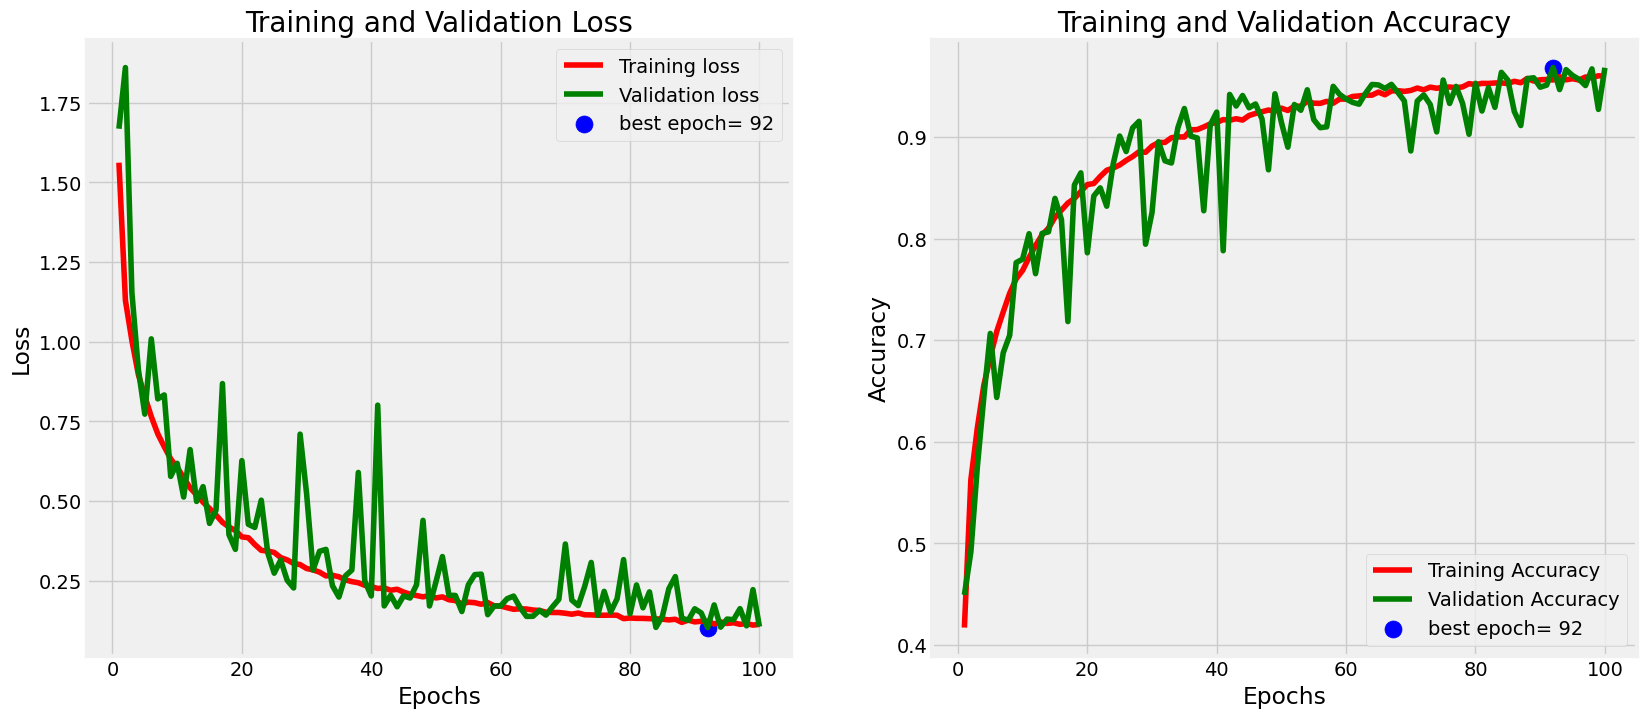

In [24]:
# vizualizare date 

from matplotlib import pyplot as plt
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [25]:
#-----------------------------------------------------------
model.save('VRES_skin_mnist0_v4.keras')  # numele e bine sa contine informatii minimale despre model proces antrenare etc. 

In [26]:
print(classes)

{4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2: ('bkl', 'benign keratosis-like lesions'), 1: ('bcc', ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'), 3: ('df', 'dermatofibroma')}


# 6. Evaluare matrice confuzie 

In [27]:

# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Loading the Lowest validation loss Model 
model = load_model('best_model.keras')
from sklearn.metrics import classification_report, confusion_matrix

if datagen:
    t1=ti.time()
    if test_exists:
        accuracy = model.evaluate(test_generator)[1] 
    else:
        accuracy = model.evaluate(validation_generator)[1] 
    t2=ti.time()
    print(f"Acuratete set test = {accuracy*100} %")
    print ('Martime model (parametri): ',model.count_params())
    print('Latenta per intreg set test: ', 1000*(t2-t1), 'mili seconds')
    if test_exists:
        mygen=test_generator
        my_latency=truncate_float(1000*(t2-t1)/N_test,2)
        print ('Timp predictie per esantion in setul de test: ',my_latency, 'ms' )
    else: 
        mygen=validation_generator
        my_latency=truncate_float(1000*(t2-t1)/batch_size,2)
        print ('Timp predictie per esantion in setul de validare: ',my_latency, 'ms' )
    for i,j in mygen:
        print(i.shape, j.shape)
        p = model.predict(i)
        pq= p.argmax(-1)
        labels=(np.dot(j,np.array(range(num_classes)).T)).astype('int16')
        break;
    print(classification_report(labels,pq))
    print(confusion_matrix(labels,pq))
else:
    
   # Confusion matrix and more specific performance indicators
    #----------------------------------------------------------------

    labels=(np.dot(y_test,np.array(range(num_classes)).T)).astype('int16')
    t1=ti.time()
    pred= model.predict(x_test)
    t2=ti.time()
    my_latency=truncate_float(1000*(t2-t1)/(x_test.shape[0]),2)
    print ('Timp predictie per esantion in setul de validare: ',my_latency, 'ms' )
    
    predicted_class_indices=np.argmax(pred,axis=1)
    C=confusion_matrix(predicted_class_indices,labels)
    print (C)
    print('Classification Report')
    print(classification_report(labels,predicted_class_indices ))

if test_exists:
    tsts='|TestData|Ts_acc: '+str(best_ts)
else: 
    tsts='ValData|Val_acc:'+str(best_ts)
    
rep=model_name+'_'+dataset+' Sz|'+str(dsz)+' Bt|'+str(batch_size)+' Ep|'+str(epoci)
rep=rep+' Tep|'+str(my_eptr)+' Kpar|'+str(kpars)+' Vacc|'+str(best_val)+' TrAcc|'+str(best_tr)
rep=rep+tsts+' Lat|'+str(my_latency)
print('Repname: '+rep)

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Timp predictie per esantion in setul de validare:  0.23 ms
[[1359    0    5    0   13    0    0]
 [   0 1318    3    0   27    0    1]
 [   0    0 1215    0   54    0    5]
 [   0    0    0 1351    5    0    0]
 [   0    0   28    0 1157    0   29]
 [   0    0    0    0    3 1358    0]
 [   0    0   11    0  115    0 1330]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1359
           1       0.98      1.00      0.99      1318
           2       0.95      0.96      0.96      1262
           3       1.00      1.00      1.00      1351
           4       0.95      0.84      0.89      1374
           5       1.00      1.00      1.00      1358
           6       0.91      0.97      0.94      1365

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387

Repname: VRES_

In [28]:
#Afisare si adaugare in fisierul .csv
import pandas as pd
import os

csv_filename='jurnal.csv'

data = {
    "Model": [model_name],
    "Dataset": [dataset],
    "Img Size": [dsz],
    "Batch Size": [batch_size],
    "Epochs": [epoci],
    "Time/Epoch (s)": [my_eptr],  
    "K-Params": [kpars],  
    "Val Acc (%)": [best_val],  
    "Train Acc (%)": [best_tr],  
    "Latency (ms)": [my_latency],  
    "Test/Val Acc (%)": [best_ts] if test_exists else [best_ts]
}

df = pd.DataFrame(data)

df.to_csv(csv_filename, mode = 'a' , index= False, header=not os.path.exists(csv_filename))
print(f'REzultatele au fost salvate in{csv_filename}')
print(df)

file=pd.read_csv('jurnal.csv')
print(file)


REzultatele au fost salvate injurnal.csv
                                        Model     Dataset  Img Size  \
0  VRES_Sr0_[70, 80, 90, 100]_[2, 1, 1, 1]_[]  skin-mnist        28   

   Batch Size  Epochs  Time/Epoch (s)  K-Params  Val Acc (%)  Train Acc (%)  \
0          64     100             6.8      65.0        96.81           96.0   

   Latency (ms)  Test/Val Acc (%)  
0          0.23             96.81  
                                        Model     Dataset  Img Size  \
0  VRES_Sr0_[70, 80, 90, 100]_[2, 1, 1, 1]_[]  skin-mnist        28   

   Batch Size  Epochs  Time/Epoch (s)  K-Params  Val Acc (%)  Train Acc (%)  \
0          64     100             6.8      65.0        96.81           96.0   

   Latency (ms)  Test/Val Acc (%)  
0          0.23             96.81  


# Conversie .tflite
adaptat dupa https://saturncloud.io/blog/convert-keras-mobilenet-model-to-tflite-with-8bit-quantization-a-comprehensive-guide/

In [29]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Necesar in Keras 3 pentru compatibilizare cu formatul TF 
# exporta in format tf export 
model = load_model('best_model.keras')
model.export('some', format="tf_saved_model")
# # incarca modelul exportat 
import tensorflow as tf 
mod=tf.saved_model.load('some')

Saved artifact at 'some'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor_1CLONE')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135308731585056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731590864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731595616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731589632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731619936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731620640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731625392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731624864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731624512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731626272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135308731623632: Tens

In [30]:
# conversie tf.lite 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
# may be useful : https://medium.com/@hellokhorshed/a-step-by-step-guide-to-convert-keras-model-to-tensorflow-lite-tflite-model-6c8d08707488
# se pot incerca diverse formule de cuantizare de ex. cea de mai jos 
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Salvarea modelului TensorFlow Lite într-un fișier
#tflite_file = f'{model_name}_{dataset}.tflite'
tflite_file='best_tf.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("Conversia a fost realizată cu succes și modelul a fost salvat ca: ",tflite_file)

Conversia a fost realizată cu succes și modelul a fost salvat ca:  best_tf.tflite


In [31]:
# evaluare dimensiuni fisiere (se observa compresia consistenta in .tflite)
print("Model Sizes:")
!ls -lh | awk '{print $5 "\t" $9}'

Model Sizes:
	
893K	best_model.keras
110K	best_tf.tflite
218	jurnal.csv
4.0K	my_skin_dataset
4.0K	some
892K	VRES_skin_mnist0_v4.keras


# Evaluare performanta model .tflite 

In [33]:
# absolut necesare pentru a se putea lucra mai departe 
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/best_tf.tflite' )  # 
interpreter.allocate_tensors()

**Din motive inca neclare modelul V-CNN din site conduce la .tflite la concentrarea datelor pe 1-5 linii din matricea de confuzie** 
Cele de mai sus valabile si pentru modelul functional derivat din VRES !
este Ok pentru VRES 

In [34]:
# evaluare acuratete pe tot setul de date 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

my_numbatches=80  # se alege astfel incat inmultit cu batch_size sa fie mai mare 
# decat numarul de esantioane din setul de validare sau test (daca exista)
if datagen: 
    acc, pred, lat = evaluate_model(interpreter, num_batches=my_numbatches, x_test=[], y_test=[])
else:
    acc, pred, lat = evaluate_model(interpreter, num_batches=[], x_test=x_test, y_test=y_test)
print('Acuratetea pe modelul .tflite este de', 100*acc,'%', 'Latentza: ',lat,' ms')

[[1359    0    8    0   13    0    0]
 [   0 1318    3    0   27    0    3]
 [   0    0 1213    0   52    0    3]
 [   0    0    0 1351    4    0    0]
 [   0    0   27    0 1159    0   28]
 [   0    0    0    0    3 1358    0]
 [   0    0   11    0  116    0 1331]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1359
           1       0.98      1.00      0.99      1318
           2       0.96      0.96      0.96      1262
           3       1.00      1.00      1.00      1351
           4       0.95      0.84      0.90      1374
           5       1.00      1.00      1.00      1358
           6       0.91      0.98      0.94      1365

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387

Acuratetea pe modelul .tflite este de 96.82539682539682 % Latentza:  0.5653110240815584  ms


In [35]:
#Afisare si adaugare in fisierul .csv
import pandas as pd
import os

csv_filename='rezultate_finale.csv'

data = {
    "Model": [model_name],  
    "K-Params": [kpars],  
    "Test/Val Acc (%)": [best_ts] if test_exists else [best_ts],
    "Latency [ms]": [my_latency],  
    "Nume fisier tflite" : [tflite_file],
    "Acurate model tflite [%]" : [100*acc],
    "Latenta modelului tflite [ms]" : [lat]
    
}

df = pd.DataFrame(data)

df.to_csv(csv_filename, mode = 'a' , index= False, header=not os.path.exists(csv_filename))
print(f'REzultatele au fost salvate in{csv_filename}')
print(df)

file=pd.read_csv('rezultate_finale.csv')
print(file)


REzultatele au fost salvate inrezultate_finale.csv
                                        Model  K-Params  Test/Val Acc (%)  \
0  VRES_Sr0_[70, 80, 90, 100]_[2, 1, 1, 1]_[]      65.0             96.81   

   Latency [ms] Nume fisier tflite  Acurate model tflite [%]  \
0          0.23     best_tf.tflite                 96.825397   

   Latenta modelului tflite [ms]  
0                       0.565311  
                                        Model  K-Params  Test/Val Acc (%)  \
0  VRES_Sr0_[70, 80, 90, 100]_[2, 1, 1, 1]_[]      65.0             96.81   

   Latency [ms] Nume fisier tflite  Acurate model tflite [%]  \
0          0.23     best_tf.tflite                 96.825397   

   Latenta modelului tflite [ms]  
0                       0.565311  


# 7. Predictie


In [36]:
import numpy as np
import tensorflow as tf
from PIL import Image

def predict_tflite(model_path, image_path, input_shape=(28, 28, 3)):
    # Încarcă modelul TFLite
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Obține detalii despre input și output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Încarcă imaginea și redimensioneaz-o
    image = Image.open(image_path).convert("RGB")
    image = image.resize((input_shape[0], input_shape[1]))
    image = np.array(image, dtype=np.float32)  # Fără normalizare
    image = np.expand_dims(image, axis=0)  # Adaugă batch dimension
    
    # Rulează inferența
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    
    # Obține rezultatele
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data, axis=1)[0]
    
    # Găsește eticheta corespunzătoare
    label = classes.get(predicted_class, ("Unknown", "Unknown"))
    
    return predicted_class, label, output_data

In [37]:
lista = [
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024312.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024313.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024315.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024316.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024318.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024324.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024329.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024372.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024396.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024402.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024403.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024411.jpg',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024475.jpg'
]

model_tflite = "best_tf.tflite"  # Calea către modelul tău TFLite


In [38]:
for path in lista:
    predicted_class, label, output_scores = predict_tflite(model_tflite, path)
    print(path)
   # print(f"Clasa prezisă: {predicted_class}")
    print(f"Eticheta: {label[0]} - {label[1]}")
   # print(f"Scorurile de ieșire: {output_scores}")
    print("\n")

/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg
Eticheta: nv -  melanocytic nevi


/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024312.jpg
Eticheta: bkl - benign keratosis-like lesions


/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024313.jpg
Eticheta: mel - melanoma


/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024315.jpg
Eticheta: mel - melanoma


/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024316.jpg
Eticheta: nv -  melanocytic nevi


/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024318.jpg
Eticheta: df - dermatofibroma


/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024324.jpg
Eticheta: bkl - benign keratosis-like lesions


/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024329.jpg
Eticheta: akiec - Actinic keratoses and intraepithelial carcinomae


/kaggle/input/skin-cancer-mnist